In [51]:
import numpy as np
import pandas as pd
import sklearn
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


## 0. Loading DataSet

In [2]:
data_set = np.genfromtxt('magic04.data', delimiter=',', dtype=str) # Data is in the form of array of tuples
labels = data_set[:, len(data_set[0]) - 1:len(data_set[0])]

# 1. Data Balancing

In [3]:
under_sampler = RandomUnderSampler()
sampled_data, sampled_labels = under_sampler.fit_resample(data_set, labels)

In [4]:
unique, counts = np.unique(labels, return_counts=True)
print(dict(zip(unique, counts)))
unique, counts = np.unique(sampled_labels, return_counts=True)
print(dict(zip(unique, counts)))

{'g': 12332, 'h': 6688}
{'g': 6688, 'h': 6688}


# 2. Data Split


In [5]:
training_data_set, testing_data_set = train_test_split(data_set, test_size=0.3)

In [6]:
training_data = np.array(training_data_set[:, 0:len(training_data_set[0]) - 1]).astype(np.float64)
training_labels = training_data_set[:, len(training_data_set[0]) - 1:len(training_data_set[0])]
training_labels = np.reshape(training_labels, len(training_labels))

In [7]:
testing_data = np.array(testing_data_set[:, 0:len(testing_data_set[0]) - 1]).astype(np.float64)
testing_labels = testing_data_set[:, len(testing_data_set[0]) - 1:len(testing_data_set[0])]
testing_labels = np.reshape(testing_labels, len(testing_labels))

# 3. Classification

In [8]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier

### (a) Decision Tree

In [9]:
def decision_tree(tr_data, tr_labels, tst_data):
    decision_tree = tree.DecisionTreeClassifier()
    decision_tree_pred = decision_tree.fit(tr_data, tr_labels).predict(tst_data)
    return decision_tree_pred

### (b) AdaBoost

In [10]:
def ada_boost(tr_data, tr_labels, tst_data, n_estimators):
    ada_boost = AdaBoostClassifier(n_estimators=n_estimators)
    ada_boost_pred = ada_boost.fit(tr_data, tr_labels).predict(tst_data)
    return ada_boost_pred
    

### (c) K-Nearest Neighbors (K-NN)

In [11]:
def knn(tr_data, tr_labels, tst_data, k_neighb = 3):
    neigh = KNeighborsClassifier(n_neighbors=k_neighb)
    knn_pred = neigh.fit(tr_data, tr_labels).predict(tst_data)
    return knn_pred

### (d) Random Forests


In [12]:
def random_forests(tr_data, tr_labels, tst_data, n_estimators):
    random_forests = RandomForestClassifier(n_estimators=n_estimators)
    random_forests_pred = random_forests.fit(tr_data, tr_labels).predict(tst_data)
    return random_forests_pred
    

### (e) Na¨ıve Bayes


In [13]:
def naive_bayes(tr_data, tr_labels, tst_data):
    gnb = GaussianNB()
    naive_bayes_pred = gnb.fit(tr_data, tr_labels).predict(tst_data)
    return naive_bayes_pred

# 4. Model Parameter Tuning


In [14]:
decision_tree_pred = decision_tree(training_data, training_labels, testing_data)
print("Decision tree accuracy: ", accuracy_score(testing_labels, decision_tree_pred) * 100, "%")
precision_score(testing_labels, decision_tree_pred, average='weighted')
recall_score(testing_labels, decision_tree_pred, average='weighted')
f1_score(testing_labels, decision_tree_pred, average='weighted')

Decision tree accuracy:  82.05397826848932 %


0.8201452868357041

In [15]:
naive_bayes_pred = naive_bayes(training_data, training_labels, testing_data)
print("Na¨ıve bayes accuracy: ", accuracy_score(testing_labels, naive_bayes_pred) * 100, "%")
precision_score(testing_labels, naive_bayes_pred, average='weighted')
recall_score(testing_labels, naive_bayes_pred, average='weighted')
f1_score(testing_labels, naive_bayes_pred, average='weighted')

Na¨ıve bayes accuracy:  73.20364528566421 %


0.7045160711435898

In [16]:
k_neighb = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
for k in k_neighb:
    knn_pred = knn(training_data, training_labels, testing_data, k)
    print(str(k) + "-NN accuracy: ", accuracy_score(testing_labels, knn_pred) * 100, "%")
    precision_score(testing_labels, knn_pred, average='weighted')
    recall_score(testing_labels, knn_pred, average='weighted')
    f1_score(testing_labels, knn_pred, average='weighted')

1-NN accuracy:  78.00560813179109 %
2-NN accuracy:  78.51384507535927 %
3-NN accuracy:  79.81072555205047 %
4-NN accuracy:  79.72309849281459 %
5-NN accuracy:  80.37153873116019 %
6-NN accuracy:  80.26638626007711 %
7-NN accuracy:  80.56431826147914 %
8-NN accuracy:  80.42411496670172 %
9-NN accuracy:  81.17770767613038 %
10-NN accuracy:  80.87977567472836 %
11-NN accuracy:  80.96740273396425 %
12-NN accuracy:  80.58184367332632 %
13-NN accuracy:  80.91482649842271 %
14-NN accuracy:  80.77462320364529 %
15-NN accuracy:  81.03750438135296 %
16-NN accuracy:  80.65194532071503 %
17-NN accuracy:  80.98492814581142 %
18-NN accuracy:  80.94987732211708 %
19-NN accuracy:  80.91482649842271 %
20-NN accuracy:  80.70452155625657 %


In [17]:
n_estimators = [90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]
for n in n_estimators:
    ada_boost_pred = ada_boost(training_data, training_labels, testing_data, n)
    print(str(n) + "_estimators AdaBoost accuracy: ", accuracy_score(testing_labels, ada_boost_pred) * 100, "%")
    precision_score(testing_labels, ada_boost_pred, average='weighted')
    recall_score(testing_labels, ada_boost_pred, average='weighted')
    f1_score(testing_labels, ada_boost_pred, average='weighted')

90_estimators AdaBoost accuracy:  84.59516298633018 %
91_estimators AdaBoost accuracy:  84.71784086926043 %
92_estimators AdaBoost accuracy:  84.68279004556607 %
93_estimators AdaBoost accuracy:  84.71784086926043 %
94_estimators AdaBoost accuracy:  84.7353662811076 %
95_estimators AdaBoost accuracy:  84.70031545741324 %
96_estimators AdaBoost accuracy:  84.7353662811076 %
97_estimators AdaBoost accuracy:  84.70031545741324 %
98_estimators AdaBoost accuracy:  84.68279004556607 %
99_estimators AdaBoost accuracy:  84.68279004556607 %
100_estimators AdaBoost accuracy:  84.70031545741324 %


In [18]:
n_estimators = [90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]
for n in n_estimators:
    random_forests_pred = random_forests(training_data, training_labels, testing_data, n)
    print(str(n) + "_estimators random forests accuracy: ", accuracy_score(testing_labels, random_forests_pred) * 100, "%")
    precision_score(testing_labels, random_forests_pred, average='weighted')
    recall_score(testing_labels, random_forests_pred, average='weighted')
    f1_score(testing_labels, random_forests_pred, average='weighted')

90_estimators random forests accuracy:  87.6621100595864 %
91_estimators random forests accuracy:  87.7497371188223 %
92_estimators random forests accuracy:  87.80231335436383 %
93_estimators random forests accuracy:  87.53943217665615 %
94_estimators random forests accuracy:  87.7497371188223 %
95_estimators random forests accuracy:  87.73221170697512 %
96_estimators random forests accuracy:  87.85488958990535 %
97_estimators random forests accuracy:  87.4167542937259 %
98_estimators random forests accuracy:  87.7497371188223 %
99_estimators random forests accuracy:  87.83736417805818 %
100_estimators random forests accuracy:  87.62705923589205 %


# 5. Report Requirements

# 6. Bonus

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn import preprocessing

In [52]:
EPOCHS = 2000

In [20]:
le = preprocessing.LabelEncoder()
training_encoded_labels = le.fit_transform(training_labels)
testing_encoded_labels = le.fit_transform(testing_labels)

In [21]:
print(f'Training Data Shape {training_data.shape}')
print(f'Training Label Shape {training_encoded_labels.shape}')

Training Data Shape (13314, 10)
Training Label Shape (13314,)


In [22]:
print(f'Training Data  {training_data[0]}')
print(f'Training Label {training_encoded_labels[0]}')

Training Data  [ 18.8834  10.09     2.444    0.5935   0.3327 -22.8136 -10.8397   4.4965
  57.86   197.527 ]
Training Label 0


In [23]:
X_train_val = torch.from_numpy(training_data).float()
X_test = torch.from_numpy(testing_data).float()
y_train_val = torch.from_numpy(training_encoded_labels).float()
y_test = torch.from_numpy(testing_encoded_labels).float()

In [24]:
print(X_train_val.shape)
print(X_test.shape)

torch.Size([13314, 10])
torch.Size([5706, 10])


In [25]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1, random_state=42) 

In [26]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

torch.Size([11982, 10])
torch.Size([1332, 10])
torch.Size([5706, 10])


In [55]:
class ClassificationModel(nn.Module):
    def __init__(self, input_layer, hidden_layer_1, hidden_layer_2, output_layer):
        super(ClassificationModel, self).__init__()
        self.l1 = nn.Linear(input_layer, hidden_layer_1)
        self.l2 = nn.Linear(hidden_layer_1, hidden_layer_2)
        self.out = nn.Linear(hidden_layer_2, output_layer)
 
    def forward(self, data):
        x = self.l1(data)
        x = torch.relu(x)
        x = self.l2(x)
        x = torch.relu(x)
        x = self.out(x)
        return torch.sigmoid(x)
     


In [114]:

def train_val_model(model, epochs, optimizer, loss_fn, X_train, X_val, y_train, y_val):
    acc_data_val = []
    acc_data_train = []
    loss_data_val = []
    loss_data_train = []

    for epoch in range(EPOCHS+1):
        optimizer.zero_grad()
        model.train()
        y_pred_train = model(X_train)
        loss_train = loss_fn(y_pred_train, y_train)
        loss_train.backward()
        optimizer.step()

        model.eval()
        y_pred_val = model(X_val)
        loss_val = loss_fn(y_pred_val, y_val)
        condition = y_pred_val >= 0.5
        y_pred_val = torch.where(condition, 1, 0)
        val_acc = torch.sum(y_pred_val == y_val) / len(y_val)

        condition = y_pred_train >= 0.5
        y_pred_train = torch.where(condition, 1, 0)
        train_acc = torch.sum(y_pred_train == y_train) / len(y_train)
        if epoch % 250 == 0:
            print(f'{epoch} : Training loss {loss_train} && Training Acc is {train_acc} || Test loss {loss_val} && Test Acc is {val_acc}')
        acc_data_val.append(val_acc)
        acc_data_train.append(train_acc)
        loss_data_val.append(loss_val)
        loss_data_train.append(loss_train)

    return acc_data_train, acc_data_val, loss_data_train, loss_data_val
            

In [109]:
model_1 = ClassificationModel(10, 16, 32, 1)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=1e-4)
acc_data_train_1, acc_data_val_1, loss_data_train_1, loss_data_val_1 = train_val_model(model_1, 2000, optimizer, loss_fn, X_train, X_val, y_train.reshape(-1, 1), y_val.reshape(-1, 1))

0 : Training loss 3.7115747928619385 && Training Acc is 0.3567851781845093 || Test loss 3.9166388511657715 && Test Acc is 0.3288288414478302
250 : Training loss 0.5859538912773132 && Training Acc is 0.685361385345459 || Test loss 0.565214216709137 && Test Acc is 0.6989489197731018
500 : Training loss 0.5236989259719849 && Training Acc is 0.7258387804031372 || Test loss 0.4930504560470581 && Test Acc is 0.7492492198944092
750 : Training loss 0.497311532497406 && Training Acc is 0.740444004535675 || Test loss 0.4650588035583496 && Test Acc is 0.7702702879905701
1000 : Training loss 0.4740244448184967 && Training Acc is 0.7739108800888062 || Test loss 0.44215139746665955 && Test Acc is 0.8070570826530457
1250 : Training loss 0.45784834027290344 && Training Acc is 0.7886829972267151 || Test loss 0.4252472519874573 && Test Acc is 0.8190690875053406
1500 : Training loss 0.4458579421043396 && Training Acc is 0.7984476685523987 || Test loss 0.4143792688846588 && Test Acc is 0.8220720887184143


In [110]:
model_2 = ClassificationModel(10, 64, 128, 1)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr=1e-4)
acc_data_train_2, acc_data_val_2, loss_data_train_2, loss_data_val_2 = train_val_model(model_2, 2000, optimizer, loss_fn, X_train, X_val, y_train.reshape(-1, 1), y_val.reshape(-1, 1))

0 : Training loss 1.7460377216339111 && Training Acc is 0.6412118077278137 || Test loss 1.3868361711502075 && Test Acc is 0.6561561822891235
250 : Training loss 0.47993940114974976 && Training Acc is 0.7598898410797119 || Test loss 0.45132917165756226 && Test Acc is 0.7867867946624756
500 : Training loss 0.43858668208122253 && Training Acc is 0.7926055788993835 || Test loss 0.41370487213134766 && Test Acc is 0.8160660862922668
750 : Training loss 0.41735294461250305 && Training Acc is 0.8107995390892029 || Test loss 0.39734193682670593 && Test Acc is 0.8280780911445618
1000 : Training loss 0.4001939594745636 && Training Acc is 0.8216491341590881 || Test loss 0.38352692127227783 && Test Acc is 0.8348348140716553
1250 : Training loss 0.38565701246261597 && Training Acc is 0.8303288221359253 || Test loss 0.37059441208839417 && Test Acc is 0.8453453183174133
1500 : Training loss 0.3739928603172302 && Training Acc is 0.8347521424293518 || Test loss 0.36395692825317383 && Test Acc is 0.84684

In [111]:
model_3 = ClassificationModel(10, 128, 512, 1)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model_3.parameters(), lr=1e-4)
acc_data_train_3, acc_data_val_3, loss_data_train_3, loss_data_val_3 = train_val_model(model_3, 2000, optimizer, loss_fn, X_train, X_val, y_train.reshape(-1, 1), y_val.reshape(-1, 1))

0 : Training loss 2.1583662033081055 && Training Acc is 0.6415456533432007 || Test loss 1.4102039337158203 && Test Acc is 0.6576576828956604
250 : Training loss 0.4358345866203308 && Training Acc is 0.7954431772232056 || Test loss 0.4188663959503174 && Test Acc is 0.815315306186676
500 : Training loss 0.4000551104545593 && Training Acc is 0.8203138113021851 || Test loss 0.39132368564605713 && Test Acc is 0.8310810923576355
750 : Training loss 0.37460264563560486 && Training Acc is 0.8369220495223999 || Test loss 0.3741660714149475 && Test Acc is 0.8438438177108765
1000 : Training loss 0.35470160841941833 && Training Acc is 0.8472709059715271 || Test loss 0.3639518618583679 && Test Acc is 0.8490990996360779
1250 : Training loss 0.3405493497848511 && Training Acc is 0.8545318245887756 || Test loss 0.3583747148513794 && Test Acc is 0.8513513803482056
1500 : Training loss 0.3299788236618042 && Training Acc is 0.8592054843902588 || Test loss 0.3590625822544098 && Test Acc is 0.8536036014556

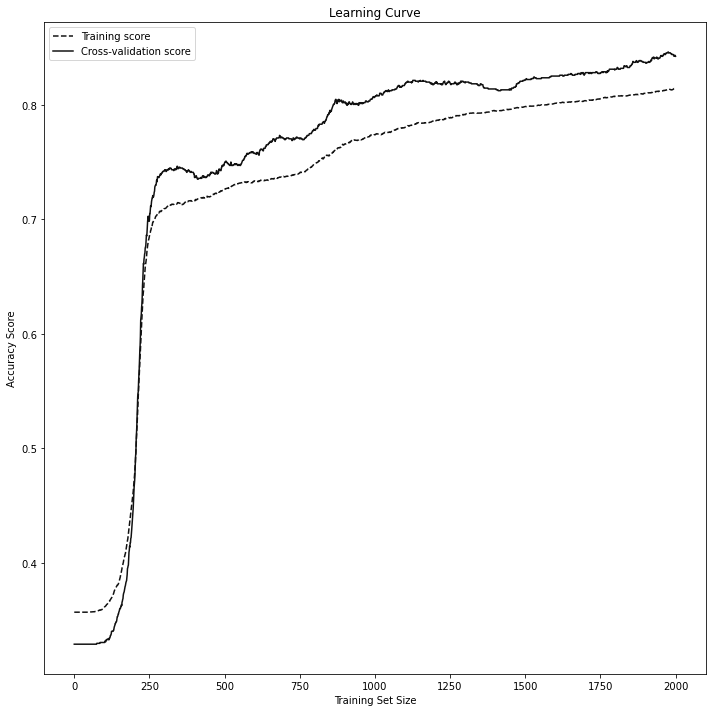

In [113]:
def plot_acc_loss(acc_data_train, acc_data_val, loss_data_train, loss_data_val):
    x_axis = range(0, EPOCHS+1)
    plt.subplot(1, 2, 1)
    plt.subplots(1, figsize=(10,10))
    plt.plot(x_axis, acc_data_train, '--', color="#111111",  label="Training score")
    plt.plot(x_axis, acc_data_val, color="#111111", label="Cross-validation score")
    plt.title("Learning Curve")
    plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
    plt.tight_layout()

    plt.subplot(1, 2, 1)
    plt.plot(x_axis, loss_data_train, '--', color="#111111",  label="Training loss")
    plt.plot(x_axis, loss_data_val, color="#111111", label="Cross-validation loss")
    plt.title("Learning Curve")
    plt.xlabel("Training Set Size"), plt.ylabel("Loss Score"), plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

In [ ]:
def evalute_test(model, X_test, y_test):
    model.eval()
    y_pred_test = model(X_test)
    cond = y_pred_test >= 0.5
    y_pred_test = torch.where(cond, 1, 0)
    train_acc = (torch.sum(y_pred_test == y_test) / len(y_test)).round(4)
    print(f"Model Acc. on Test Data {train_acc}")

### Scaling Data